<a href="https://colab.research.google.com/github/yaswanth19/RNA-Scope-Image-Analysis/blob/main/RNA_Analysis_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, feature, measure,transform,draw
from PIL import Image
import pylab
from skimage import measure, color, io
import matplotlib.patches as patches

In [ ]:
path='/content/WT F1 D1_C0.tif'
tif_image = Image.open(path)

# Convert the TIF image to RGB format
tif_image = tif_image.convert('RGB')

# Save the image as a PNG file
tif_image.save('image.png', 'PNG')

In [ ]:
path='/content/image.png'

# Load the image
img = Image.open(path)

# Set magnification factor
mag_factor = 5

# Resize the image
resized_img = img.resize((int(img.size[0]*mag_factor), int(img.size[1]*mag_factor)))

# Convert the resized image to a numpy array
original_resized= np.array(resized_img)

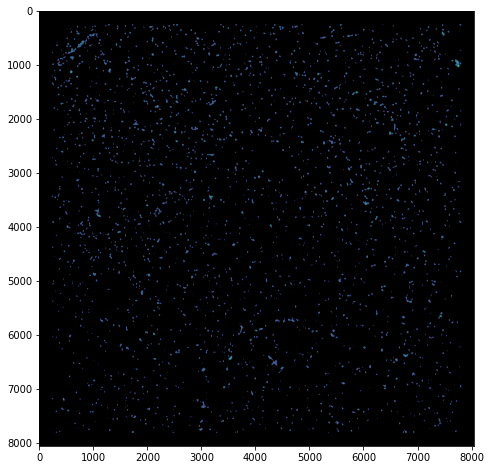

In [ ]:
# Doing basic thresholding and other processing to get a better image
lower = np.array([0, 0, 0])
upper = np.array([100, 255, 255])

# Convert the image to the HSV color space
hsv = cv2.cvtColor(original_resized, cv2.COLOR_BGR2HSV)

# Create a mask by thresholding the image in the HSV color space
mask = cv2.inRange(hsv, lower, upper)

# Apply bitwise-and to the original image and the mask to extract the particles
img_array = cv2.bitwise_and(original_resized,original_resized, mask=mask)

plt.figure(figsize=(8,8))
rgb_image=cv2.cvtColor(img_array, cv2.COLOR_BGRA2BGR)
plt.imshow(rgb_image)

# Watershed

In [ ]:
# Refered from this repo
#https://github.com/bnsreenu/python_for_microscopists/blob/master/034a-grain_size_analysis_using_wateshed_segmentation_multiple_files.py

In [ ]:
img=cv2.cvtColor(rgb_image,cv2.COLOR_BGR2GRAY)
ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [ ]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

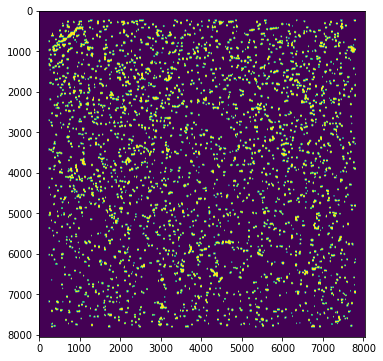

In [ ]:
#The cells became yellow while the bg is vi0let
plt.figure(figsize=(6,6))
sure_bg = cv2.dilate(opening,kernel,iterations=10)
plt.imshow(sure_bg)

In [ ]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
#Tune the multiplication factor of dist for better results
ret2, sure_fg = cv2.threshold(dist_transform,0.07*dist_transform.max(),255,0)

In [ ]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [ ]:
ret3, markers = cv2.connectedComponents(sure_fg)

In [ ]:
markers = markers+10
markers[unknown==255] = 0
markers = cv2.watershed(rgb_image,markers)

In [ ]:
rgb_image[markers == -1] = [255,255,255]  
img2 = color.label2rgb(markers, bg_label=0)

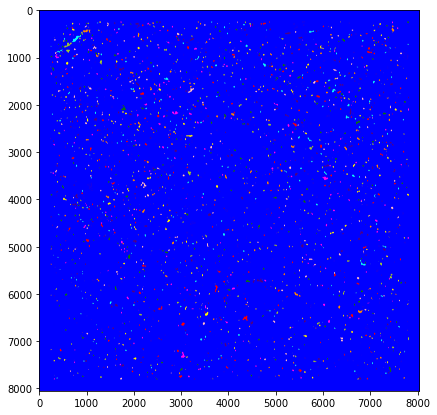

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(img2)#Shows the  watershed image color segmentation

In [ ]:
if not os.path.exists('Images/'):
  os.mkdir('Images/')
for m in np.unique(markers):
    # Skip the background marker (marker value of -1)
    if m == -1:
        continue
    
    # Create a mask for the current particle
    mask = np.zeros_like(img, dtype=np.uint8)
    mask[markers == m] = 255
    
    # Extract the particle as an ROI
    x, y, w, h = cv2.boundingRect(mask)
    roi = rgb_image[y:y+h, x:x+w]
    
    # Save the particle image
    cv2.imwrite('Images/particle_{}.png'.format(m), roi)

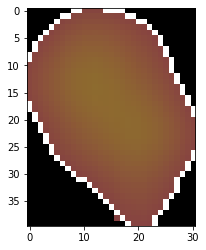

In [ ]:
test1=Image.open('/content/Images/particle_854.png')
plt.imshow(np.array(test1))

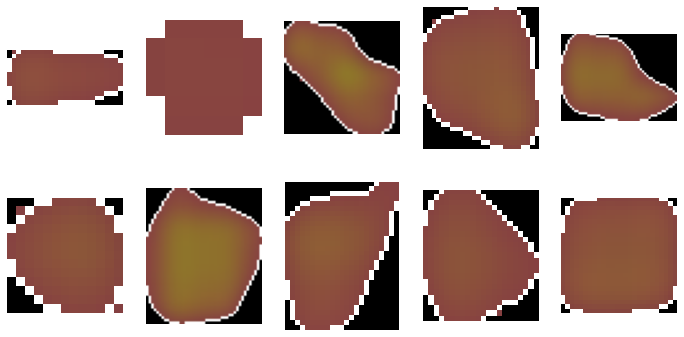

In [ ]:
import random
lst=os.listdir('/content/Images/')
random_files = random.sample(lst, 10)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, file_name in enumerate(random_files):
    # Open the image file
    image = Image.open(os.path.join('/content/Images/', file_name))
    image_array = np.array(image)
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image_array)
    axs[row, col].axis('off')

plt.show()